# Trabalho: DW de Segurança Pública

**Tema:** Segurança Pública e Vulnerabilidade Social no Brasil

**Bases:**
1.  `indicadoressegurancapublicaufocorrencias.csv` (Sinesp): Contagem de ocorrências criminais por UF e mês, de janeiro de 2015 a dezembro de 2022.
2.  `indicadoressegurancapublicaufvitimas.csv` (Sinesp): Contagem de vítimas fatais por UF e mês, de janeiro de 2018 a dezembro de 2022.
3.  `atlasivs_dadosbrutos_uf_v2.csv` (Atlas IVS/IPEA) Indicadores de vulnerabilidade social por UF e ano, de 2000 a 2022.

> **Objetivo:** Consolidar dados de segurança pública e indicadores socioeconômicos do Brasil em um **DW (Star Schema)**, realizar o processo de **ETL** com pandas e, com a base modelada, responder a perguntas de negócio sobre a relação entre vulnerabilidade social e criminalidade.

## Modelo conceitual (Star Schema)

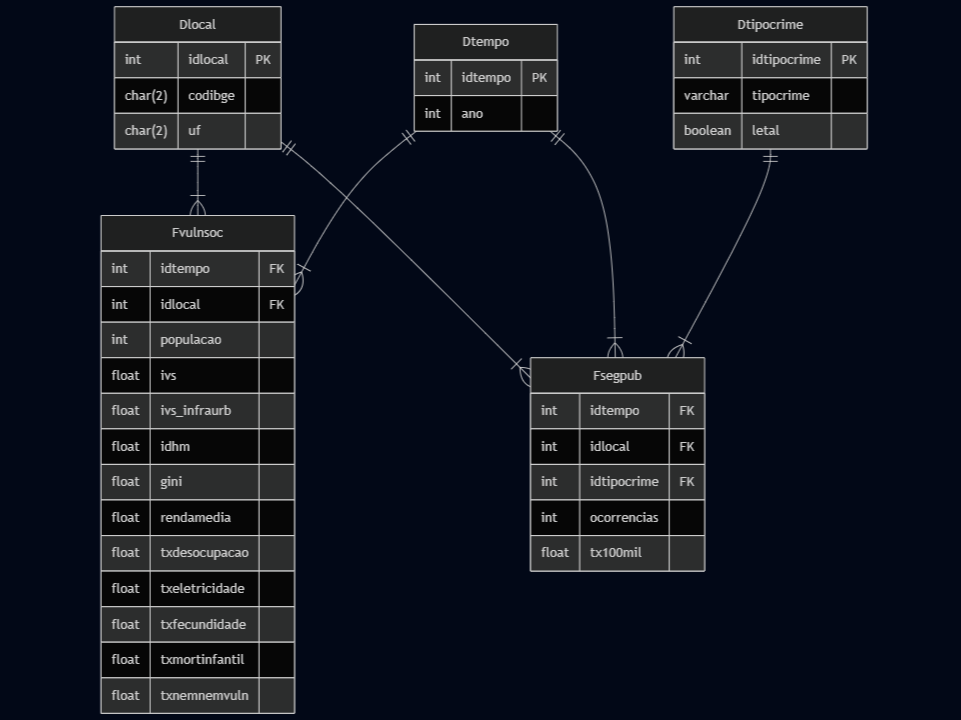

## Construção do _Data Warehouse_

### Importação dos DataFrames

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests

%matplotlib inline

# Configuração de visualização para o pandas
pd.set_option('display.max_columns', None)

# URLs dos datasets no GitHub
URL_DATA_OCORRENCIAS = 'https://raw.githubusercontent.com/felppo/trab-siad/refs/heads/main/datasets/indicadoressegurancapublicaufocorrencias.csv'
# URL_DATA_VITIMAS = 'https://raw.githubusercontent.com/felppo/trab-siad/refs/heads/main/datasets/indicadoressegurancapublicamunic.csv'
# URL_DATA_IVS_MUN = 'https://media.githubusercontent.com/media/felppo/trab-siad/refs/heads/main/datasets/atlasivs_dadosbrutos_v2.csv'
URL_DATA_IVS_UF = 'https://raw.githubusercontent.com/felppo/trab-siad/refs/heads/main/datasets/atlasivs_dadosbrutos_uf_v2.csv'

# Diretório para salvar os arquivos em cache
OUT_DIR = Path('dw_cache')
OUT_DIR.mkdir(exist_ok=True)

In [ ]:


def get_data(url):
    fname = Path(url.split('/')[-1])
    full_output = OUT_DIR/fname

    if full_output.exists():
        try:
            df = pd.read_csv(full_output, sep=';', decimal=',')
            print('✔ Lido do cache:', full_output)
            return df
        except Exception as e:
            print(f'Erro ao ler do cache {full_output}: {e}')
            pass

    try:
        df = pd.read_csv(url, sep=';', decimal=',')
        if not full_output.exists():
            df.to_csv(full_output, sep=';', index=False)
        print('✔ Lido da web:', url)
        return df

    except Exception as e:
        print('Web falhou:', e)
        print(f"Não foi possível carregar os dados de {url}")
        return None

### Extração / Tratamento

In [ ]:
# Extração dos dados

ocorrencias_df = get_data(URL_DATA_OCORRENCIAS)
atlasuf_df = get_data(URL_DATA_IVS_UF)

assert ocorrencias_df is not None, '❗ Dados não foram carregados em ocorrencias_df.'
assert atlasuf_df is not None, '❗ Dados não foram carregados em atlasuf_df.'

✔ Lido da web: https://raw.githubusercontent.com/felppo/trab-siad/refs/heads/main/datasets/indicadoressegurancapublicaufocorrencias.csv
✔ Lido da web: https://raw.githubusercontent.com/felppo/trab-siad/refs/heads/main/datasets/atlasivs_dadosbrutos_uf_v2.csv


In [ ]:
# Normalizar nomes de colunas para análise
ocorrencias_df = ocorrencias_df.rename(columns={'Tipo Crime': 'tipocrime', 'Mês': 'mes', 'Ocorrências': 'ocorrencias'})
ocorrencias_df.columns = ocorrencias_df.columns.str.lower()  # Trata atributos restantes (ano)

atlasuf_df = atlasuf_df.rename(columns={'ivs_infraestrutura_urbana': 'ivs_infraurb', 'i_gini': 'gini', 'uf': 'codibge', \
                                        'renda_per_capita': 'rendamedia', 't_desocup18m': 'txdesocupacao', \
                                        't_eletrica': 'txeletricidade', 't_fectot': 'txfecundidade', \
                                        't_fmor5' : 'txmortinfantil', 't_p15a24_nada': 'txnemnemvuln'})
atlasuf_df.columns = atlasuf_df.columns.str.lower()

# Seleção de colunas do dataframe por simplicidade
atlasuf_df = atlasuf_df[['codibge', 'ano', 'populacao', 'ivs', 'ivs_infraurb',
                         'idhm', 'gini', 'rendamedia', 'txdesocupacao',
                         'txeletricidade', 'txfecundidade', 'txmortinfantil',
                         'txnemnemvuln', 'label_cor', 'label_sexo', 'label_sit_dom']]

# Remover espaços em branco da coluna de UF
for df in [ocorrencias_df, atlasuf_df]:
    if df is not None and 'uf' in df.columns:
        df['uf'] = df['uf'].astype(str).str.strip()

In [ ]:
from pandas.core.indexes import category
# Conversão de tipos
def num_conversion(df, cols):
    # Tratamento de separador decimal e conversão
    df[cols] = df[cols].replace(",", ".", regex=True)
    df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Conversão númerica
num_conversion(ocorrencias_df, ['ano', 'ocorrencias'])
num_conversion(atlasuf_df, ['ano', 'populacao', 'ivs', 'ivs_infraurb', 'idhm',
                            'gini', 'rendamedia', 'txdesocupacao', 'txeletricidade',
                            'txfecundidade', 'txmortinfantil', 'txnemnemvuln'])

# Definir rótulos como categorias
atlasuf_df[['label_cor', 'label_sexo', 'label_sit_dom']] = atlasuf_df[['label_cor', 'label_sexo', 'label_sit_dom']].astype('category')

display(atlasuf_df.dtypes)
display(ocorrencias_df.dtypes)


,0
codibge,int64
ano,int64
populacao,float64
ivs,float64
ivs_infraurb,float64
idhm,float64
gini,float64
rendamedia,float64
txdesocupacao,float64
txeletricidade,float64


,0
uf,object
tipocrime,object
ano,int64
mes,object
ocorrencias,int64


### Visualização de conjuntos de dados tratados

In [ ]:
# Visualização dos cabeçalhos corrigidos

print("Dados de Ocorrências:")
display(ocorrencias_df.head())

print("\nDados de Vulnerabilidade Social:")
display(atlasuf_df.head())

Dados de Ocorrências:


,uf,tipocrime,ano,mes,ocorrencias
0,AC,Estupro,2022,janeiro,31
1,AC,Furto de veículo,2022,janeiro,50
2,AC,Homicídio doloso,2022,janeiro,10
3,AC,Lesão corporal seguida de morte,2022,janeiro,1
4,AC,Roubo a instituição financeira,2022,janeiro,0



Dados de Vulnerabilidade Social:


,codibge,ano,populacao,ivs,ivs_infraurb,idhm,gini,rendamedia,txdesocupacao,txeletricidade,txfecundidade,txmortinfantil,txnemnemvuln,label_cor,label_sexo,label_sit_dom
0,11,2000,588568.0,0.404,0.335,0.617,0.62,572.85,7.55,86.41,1.89,19.95,16.61,Branco,Total Sexo,Total Situação de Domicílio
1,11,2000,203230.0,NaN,NaN,0.475,0.59,314.83,3.14,63.38,2.21,23.02,25.35,Branco,Total Sexo,Rural
2,11,2000,385338.0,0.347,0.301,0.676,0.61,707.49,9.47,98.43,1.75,18.56,12.23,Branco,Total Sexo,Urbano
3,11,2000,1379787.0,0.493,0.400,0.537,0.60,467.16,9.26,83.92,2.75,36.35,18.19,Total Cor,Total Sexo,Total Situação de Domicílio
4,11,2000,496167.0,NaN,NaN,0.453,0.59,277.08,4.08,58.63,2.36,25.35,25.70,Total Cor,Total Sexo,Rural


In [ ]:
# Exemplo
atlasuf_df[(atlasuf_df['ano'] == 2022)].head()

,codibge,ano,populacao,ivs,ivs_infraurb,idhm,gini,rendamedia,txdesocupacao,txeletricidade,txfecundidade,txmortinfantil,txnemnemvuln,label_cor,label_sexo,label_sit_dom
351,11,2022,546882.0,0.169,0.103,0.774,0.48,835.06,3.25,99.75,NaN,13.47,4.85,Branco,Total Sexo,Total Situação de Domicílio
352,11,2022,122201.0,NaN,NaN,0.727,0.50,705.48,0.75,99.57,NaN,15.62,6.50,Branco,Total Sexo,Rural
353,11,2022,424681.0,0.160,0.120,0.786,0.47,872.34,3.91,99.80,NaN,12.93,4.57,Branco,Total Sexo,Urbano
354,11,2022,1822812.0,0.167,0.063,0.765,0.47,688.74,5.49,99.74,NaN,14.37,7.95,Total Cor,Total Sexo,Total Situação de Domicílio
355,11,2022,407636.0,NaN,NaN,0.711,0.49,570.73,0.83,99.80,NaN,17.01,8.86,Total Cor,Total Sexo,Rural


### Dimensão Tempo

In [ ]:
# Criação da dimensão Dtempo
datas = pd.Series(dtype='datetime64[ns]')
if 'ano' in ocorrencias_df.columns:
    datas = pd.concat([datas, ocorrencias_df['ano']])
if 'ano' in atlasuf_df.columns:
    datas = pd.concat([datas, atlasuf_df['ano']])
datas = datas.drop_duplicates().sort_values().dropna()

d_tempo = pd.DataFrame(datas, columns=['ano']).reset_index(drop=True)
assert not d_tempo.empty
d_tempo['idtempo'] = d_tempo.index + 1

d_tempo

/tmp/ipython-input-2435212899.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  datas = pd.concat([datas, ocorrencias_df['ano']])


,ano,idtempo
0,2000,1
1,2010,2
2,2011,3
3,2012,4
4,2013,5
5,2014,6
6,2015,7
7,2016,8
8,2017,9
9,2018,10


### Dimensão Local

In [ ]:
# Auxiliar de conversão
cod_sigla = {
    '11': 'RO', '12': 'AC', '13': 'AM',
    '14': 'RR', '15': 'PA', '16': 'AP',
    '17': 'TO', '21': 'MA', '22': 'PI',
    '23': 'CE', '24': 'RN', '25': 'PB',
    '26': 'PE', '27': 'AL', '28': 'SE',
    '29': 'BA', '31': 'MG', '32': 'ES',
    '33': 'RJ', '35': 'SP', '41': 'PR',
    '42': 'SC', '43': 'RS', '50': 'MS',
    '51': 'MT', '52': 'GO', '53': 'DF'
}

# Mapeamento reverso das siglas
sigla_cod = {v: int(k) for k, v in cod_sigla.items()}

In [ ]:
# Criação da dimensão Dlocal

# Criação da coluna UF para conter siglas do estado
atlasuf_df['uf'] = atlasuf_df['codibge'].astype(str).map(cod_sigla)

d_local = (
    atlasuf_df[['codibge', 'uf']]
    .drop_duplicates()
    .dropna(subset=['codibge'])
    .sort_values(['codibge'])
    .reset_index(drop=True)
)

d_local['idlocal'] = d_local.index + 1

d_local

,codibge,uf,idlocal
0,11,RO,1
1,12,AC,2
2,13,AM,3
3,14,RR,4
4,15,PA,5
5,16,AP,6
6,17,TO,7
7,21,MA,8
8,22,PI,9
9,23,CE,10


### Dimensão Tipo Crime

In [ ]:
# Auxiliar de seleção
CRIMES_LETAIS = ['Homicídio doloso', 'Lesão corporal seguida de morte', 'Roubo seguido de morte (latrocínio)']

In [ ]:
# Criação da dimensão Dtipocrime
crimes = ocorrencias_df['tipocrime'].drop_duplicates().sort_values().reset_index(drop=True)
d_tipocrime = pd.DataFrame(crimes, columns=['tipocrime']).reset_index(drop=True)
d_tipocrime['idtipocrime'] = d_tipocrime.index + 1
d_tipocrime['letal'] = d_tipocrime['tipocrime'].isin(CRIMES_LETAIS)

d_tipocrime

,tipocrime,idtipocrime,letal
0,Estupro,1,False
1,Furto de veículo,2,False
2,Homicídio doloso,3,True
3,Lesão corporal seguida de morte,4,True
4,Roubo a instituição financeira,5,False
5,Roubo de carga,6,False
6,Roubo de veículo,7,False
7,Roubo seguido de morte (latrocínio),8,True
8,Tentativa de homicídio,9,False


### Tabela Fato Fvulnsoc

In [ ]:
# Criação da tabela Fato Fvulnsoc

assert not atlasuf_df.empty
f_vulnsoc = atlasuf_df.copy()

# Remoção de entradas com base em categorias que trazem ambiguidade
f_vulnsoc = f_vulnsoc[
    (f_vulnsoc['label_cor'] == 'Total Cor') &
    (f_vulnsoc['label_sexo'] == 'Total Sexo') &
    (f_vulnsoc['label_sit_dom'] == 'Total Situação de Domicílio')
]

f_vulnsoc = f_vulnsoc.drop(columns=['label_cor', 'label_sexo', 'label_sit_dom'])

# Substituição de valores por chaves estrangeiras
f_vulnsoc = pd.merge(f_vulnsoc, d_local[['idlocal', 'uf']], on='uf', how='left')
f_vulnsoc = pd.merge(f_vulnsoc, d_tempo, on='ano', how='left')
f_vulnsoc = f_vulnsoc.drop(columns=['ano', 'codibge', 'uf'])

assert not f_vulnsoc[['idlocal', 'idtempo']].isnull().any().any(), 'Há chaves estrangeiras nulas'

f_vulnsoc.head()

,populacao,ivs,ivs_infraurb,idhm,gini,rendamedia,txdesocupacao,txeletricidade,txfecundidade,txmortinfantil,txnemnemvuln,idlocal,idtempo
0,1379787.0,0.493,0.400,0.537,0.60,467.16,9.26,83.92,2.75,36.35,18.19,1,1
1,1562409.0,0.319,0.231,0.690,0.56,670.82,5.19,97.26,2.16,19.34,10.29,1,2
2,1690710.0,0.238,0.132,0.711,0.50,613.71,2.64,98.77,1.70,15.81,8.11,1,3
3,1712488.0,0.218,0.090,0.722,0.48,633.33,4.08,99.53,1.67,15.90,6.56,1,4
4,1733265.0,0.230,0.125,0.719,0.47,621.39,4.31,99.89,1.67,15.96,8.44,1,5


### Tabela Fato Fsegpub

In [ ]:
# Criação da tabela Fsegpub

assert not ocorrencias_df.empty
f_segpub = ocorrencias_df.copy()

# Agregação de ocorrências por UF, ano e tipo crime
f_segpub = f_segpub.groupby(['uf', 'ano', 'tipocrime'], as_index=False)['ocorrencias'].sum()

# Substituição de valores por chaves estrangeiras
f_segpub = f_segpub.merge(d_tempo, on="ano", how="left")
f_segpub = f_segpub.merge(d_local, on="uf", how="left")
f_segpub = f_segpub.merge(d_tipocrime, on="tipocrime", how="left")
f_segpub = f_segpub.drop(columns=['ano', 'uf', 'letal', 'tipocrime'])

assert not f_segpub[['idlocal', 'idtempo', 'idtipocrime']].isnull().any().any(), 'Há chaves estrangeiras nulas'
f_segpub['ocorrencias'] = f_segpub['ocorrencias'].fillna(0)

# Cômputo da taxa de ocorrências de crimes por 100 mil habitantes
f_segpub = f_segpub.merge(f_vulnsoc[['idlocal', 'idtempo', 'populacao']], on=['idlocal', 'idtempo'], how='left')
f_segpub['tx100mil'] = f_segpub['ocorrencias'] / f_segpub['populacao']
f_segpub = f_segpub.drop(columns=['codibge', 'populacao'])

f_segpub

,ocorrencias,idtempo,idlocal,idtipocrime,tx100mil
0,42,7,2,1,0.000052
1,0,7,2,2,0.000000
2,189,7,2,3,0.000234
3,3,7,2,4,0.000004
4,0,7,2,5,0.000000
...,...,...,...,...,...
1933,10,14,7,5,0.000006
1934,0,14,7,6,0.000000
1935,416,14,7,7,0.000258
1936,17,14,7,8,0.000011


## Backup de tabelas do DW

In [ ]:
# Salva as tabelas do DW em arquivos CSV
OUTPUT_DIR = OUT_DIR / 'dw_output'
OUTPUT_DIR.mkdir(exist_ok=True)

if 'd_tempo' in locals() and d_tempo is not None and not d_tempo.empty:
    d_tempo.to_csv(OUTPUT_DIR / 'd_tempo.csv', index=False)
else:
    print("❗ d_tempo não foi salva.")

if 'd_local' in locals() and d_local is not None and not d_local.empty:
    d_local.to_csv(OUTPUT_DIR / 'd_local.csv', index=False)
else:
    print("❗ d_local não foi salva.")

if 'd_tipocrime' in locals() and d_tipocrime is not None and not d_tipocrime.empty:
    d_tipocrime.to_csv(OUTPUT_DIR / 'd_tipocrime.csv', index=False)
else:
    print("❗ d_tipocrime não foi salva.")

if 'f_vulnsoc' in locals() and f_vulnsoc is not None and not f_vulnsoc.empty:
    f_vulnsoc.to_csv(OUTPUT_DIR / 'f_vulnsoc.csv', index=False)
else:
    print("❗ f_vulnsoc não foi salva.")

if 'f_segpub' in locals() and f_segpub is not None and not f_segpub.empty:
    f_segpub.to_csv(OUTPUT_DIR / 'f_segpub.csv', index=False)
else:
    print("❗ f_segpub não foi salva.")

print(f"Tabelas do DW salvas em {OUTPUT_DIR}.")

Tabelas do DW salvas em dw_cache/dw_output.


## Análise

### Pergunta 1

*Qual correlação é válida entre indicadores de vulnerabilidade social e a segurança pública no país?*

In [ ]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()

p1_fsegpub = f_segpub.set_index(['idlocal', 'idtempo', 'idtipocrime'])
p1_fvulnsoc = f_vulnsoc.set_index(['idlocal', 'idtempo'])
p1_join = p1_fvulnsoc.join(p1_fsegpub, how="inner")
p1_join_scaled = scaler.fit_transform(p1_join)
p1_join = pd.DataFrame(p1_join_scaled, columns=p1_join.columns, index=p1_join.index)

p1_join.head()

populacao       ivs  ivs_infraurb      idhm  \
idlocal idtempo idtipocrime                                                
1       7       1             -0.65875 -0.900989      -1.64063 -0.537421   
                2             -0.65875 -0.900989      -1.64063 -0.537421   
                3             -0.65875 -0.900989      -1.64063 -0.537421   
                4             -0.65875 -0.900989      -1.64063 -0.537421   
                5             -0.65875 -0.900989      -1.64063 -0.537421   

                                 gini  rendamedia  txdesocupacao  \
idlocal idtempo idtipocrime                                        
1       7       1           -1.257788   -0.298754      -1.481679   
                2           -1.257788   -0.298754      -1.481679   
                3           -1.257788   -0.298754      -1.481679   
                4           -1.257788   -0.298754      -1.481679   
                5           -1.257788   -0.298754      -1.481679   

                             txeletricidade  txfecundidade  txmortinfantil  \
idlocal idtempo idtipocrime                                                  
1       7       1                  0.315379       0.530746       -0.276087   
                2                  0.315379       0.530746       -0.276087   
                3                  0.315379       0.530746       -0.276087   
                4                  0.315379       0.530746       -0.276087   
                5                  0.315379       0.530746       -0.276087   

                             txnemnemvuln  ocorrencias  tx100mil  
idlocal idtempo idtipocrime                                       
1       7       1               -0.401679    -0.217822  0.241792  
                2               -0.401679     0.109377  3.682026  
                3               -0.401679    -0.242249 -0.015040  
                4               -0.401679    -0.304131 -0.665682  
                5               -0.401679    -0.302378 -0.647243

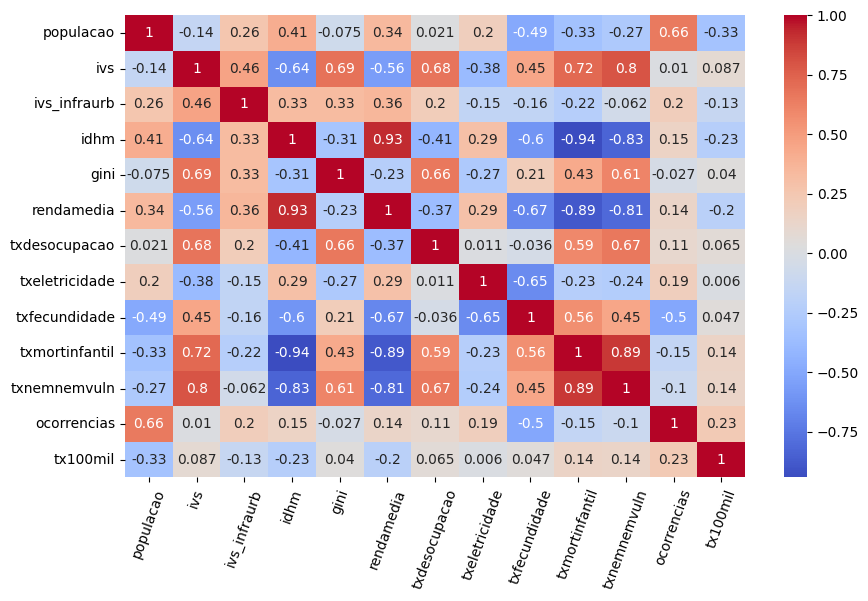

In [ ]:
# O parâmetro numérico para xs() filtra pelo valor associado à coluna em level
p1_join = pd.concat([
    p1_join.xs(3, level='idtipocrime'),
    p1_join.xs(9, level='idtipocrime')
], ignore_index=True)

plt.figure(figsize=(10,6))
sns.heatmap(p1_join.corr(), annot=True, cmap="coolwarm")
# plt.title("Matriz de Correlação")
plt.xticks(rotation=70)
plt.show()

### Pergunta 2

*Quais potenciais correlações de indicadores contrariam o senso comum?*

In [ ]:
# Mesclar f_segpub com d_local e d_tipocrime para obter 'uf' e 'tipocrime'
df_analise = f_segpub.merge(d_local[['idlocal', 'uf']], on='idlocal', how='left')
df_analise = df_analise.merge(d_tipocrime[['idtipocrime', 'tipocrime']], on='idtipocrime', how='left')

# Adicionar a coluna 'ano' de d_tempo a df_analise
df_analise = df_analise.merge(d_tempo[['idtempo', 'ano']], on='idtempo', how='left')

# Mesclar com f_vulnsoc para incluir os indicadores do atlas
df_analise = df_analise.merge(f_vulnsoc, on=['idlocal', 'idtempo'], how='left', suffixes=('_segpub', '_vulnsoc'))

# Definir colunas numéricas do atlas
cols_numericas_atlas = ['populacao', 'ivs', 'ivs_infraurb', 'idhm', 'gini', 'rendamedia',
                      'txdesocupacao', 'txeletricidade', 'txfecundidade', 'txmortinfantil', 'txnemnemvuln']

# Preparar Matriz de Correlação
df_pivot = df_analise.pivot_table(index=['uf', 'ano'] + cols_numericas_atlas,
                                  columns='tipocrime',
                                  values='tx100mil').reset_index()

crimes_interesse = ['Homicídio doloso', 'Roubo de veículo', 'Estupro', 'Roubo de carga'] # Ajuste conforme seus dados
cols_correlacao = ['idhm', 'ivs', 'rendamedia', 'gini', 'txdesocupacao'] + [c for c in crimes_interesse if c in df_pivot.columns]

corr_matrix = df_pivot[cols_correlacao].corr()

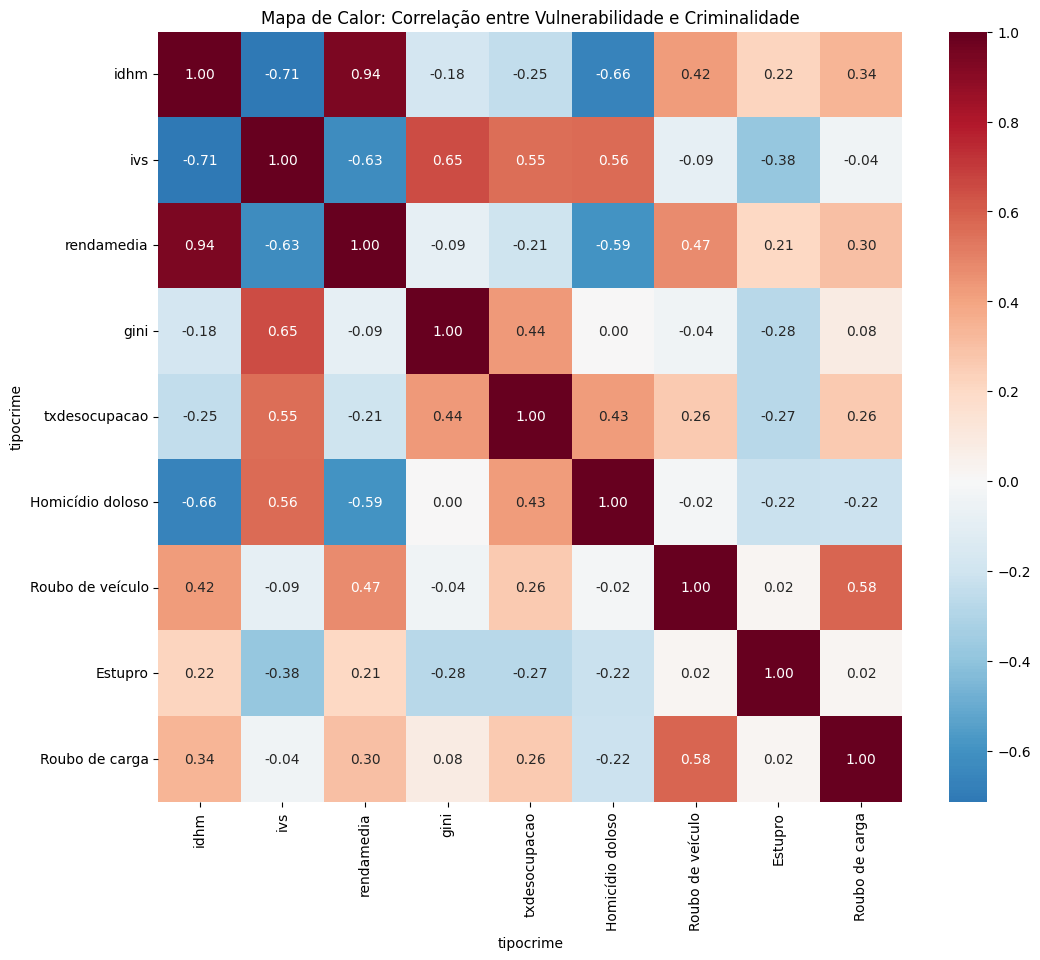

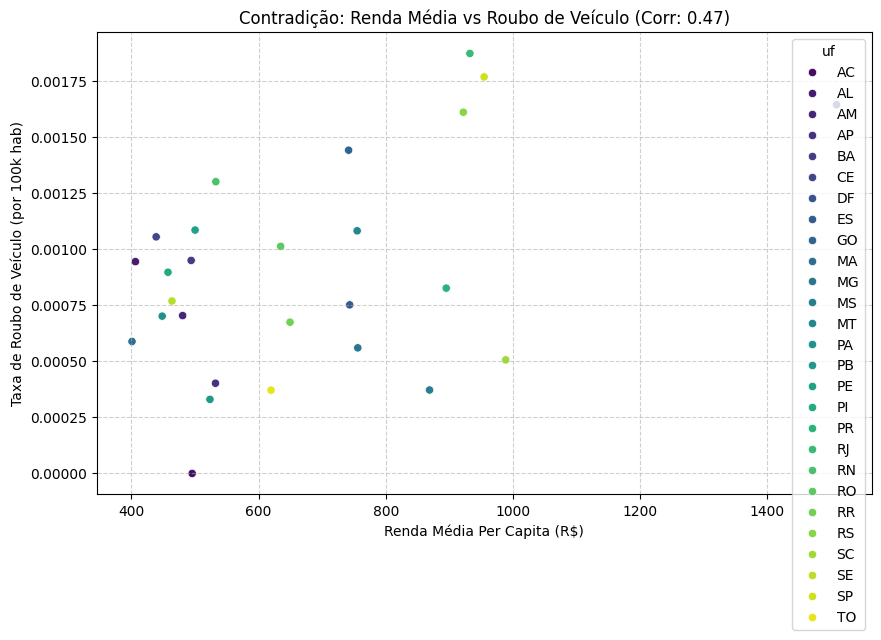

In [ ]:
# Visualização

# Mapa de Calor (Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title('Mapa de Calor: Correlação entre Vulnerabilidade e Criminalidade')
plt.show()

# Contradição ao Senso Comum (Scatter Plot)
if 'Roubo de veículo' in df_pivot.columns and 'rendamedia' in df_pivot.columns:
    corr_val = corr_matrix.loc['rendamedia', 'Roubo de veículo']
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_pivot, x='rendamedia', y='Roubo de veículo', hue='uf', palette='viridis')
    plt.title(f'Contradição: Renda Média vs Roubo de Veículo (Corr: {corr_val:.2f})')
    plt.xlabel('Renda Média Per Capita (R$)')
    plt.ylabel('Taxa de Roubo de Veículo (por 100k hab)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Colunas necessárias para o gráfico de contradição não encontradas.")

### Pergunta 3

*É possível realizar uma análise preditiva sobre a criminalidade com base nos indicadores escolhidos e dados disponíveis?*

In [ ]:
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score

In [ ]:
matching_years = np.arange(7, 15)

def get_df_features_tc(id_uf, id_tc):

    X_df = f_vulnsoc[(f_vulnsoc['idlocal'] == id_uf)].copy()
    y_df = f_segpub[(f_segpub['idlocal'] == id_uf) & (f_segpub['idtipocrime'] == id_tc)].copy()

    X_df = X_df[X_df['idtempo'].isin(matching_years)]
    y_df = y_df[y_df['idtempo'].isin(matching_years)]

    feature_cols = [
        col for col in X_df.columns
        if col not in ['idlocal', 'idtempo', 'txfecundidade', 'populacao']
                                                # txfecundidade contém NaN
                                                # populacao tem influência insignificante (baseado em testes e observações)
    ]

    Xs = X_df[feature_cols].to_numpy(dtype=float)
    ys = y_df['ocorrencias'].to_numpy(dtype=float)

    return normalize(Xs, norm="max"), ys, feature_cols

def get_df_features_uf(id_uf, id_tc):

    X_df = f_vulnsoc[(f_vulnsoc['idlocal'] == id_tc)].copy()
    y_df = f_segpub[(f_segpub['idlocal'] == id_uf) & (f_segpub['idtipocrime'] == id_tc)].copy()

    X_df = X_df[X_df['idtempo'].isin(matching_years)]
    y_df = y_df[y_df['idtempo'].isin(matching_years)]

    feature_cols = [
        col for col in X_df.columns
        if col not in ['idlocal', 'idtempo', 'txfecundidade', 'populacao']
                                                # txfecundidade contém NaN
                                                # populacao tem influência insignificante (baseado em testes e observações)
    ]

    Xs = X_df[feature_cols].to_numpy(dtype=float)
    ys = y_df['ocorrencias'].to_numpy(dtype=float)

    return normalize(Xs, norm="max"), ys, feature_cols

MSE:  26505.978880779756
MAPE:  23.500777924848602 %


Coeficientes - LASSO:
          feature        coef
0             ivs    0.000000
1    ivs_infraurb -215.976550
2            idhm  -13.633740
3            gini    0.000000
4      rendamedia    0.000000
5   txdesocupacao    0.000000
6  txeletricidade   -0.000000
7  txmortinfantil   -0.000000
8    txnemnemvuln  148.246303




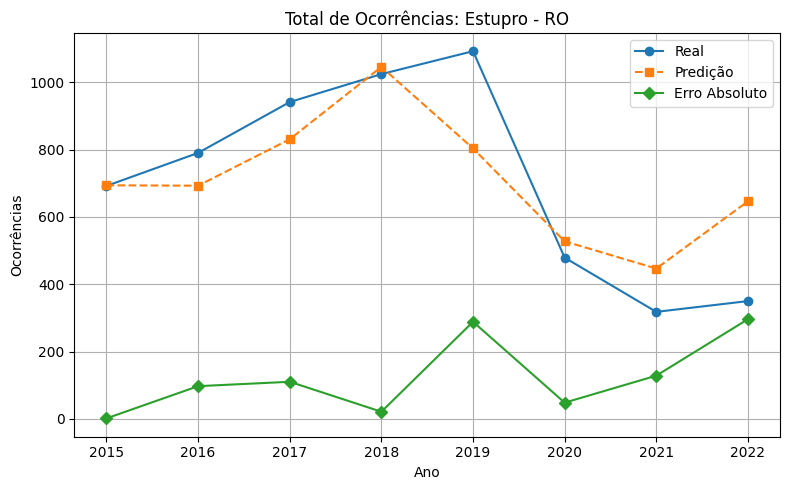


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  31576.4375
MAPE:  174.35003429969044 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm   0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao   0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln  -0.0




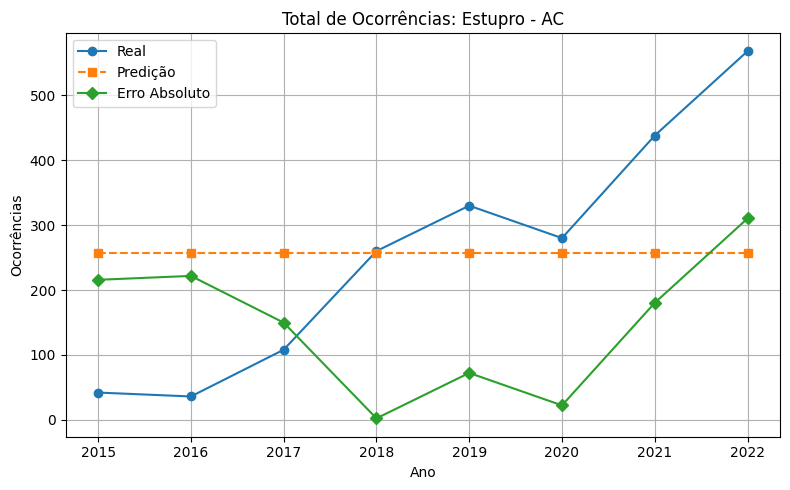


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  10560.734375
MAPE:  11.224056556187504 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm  -0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln   0.0




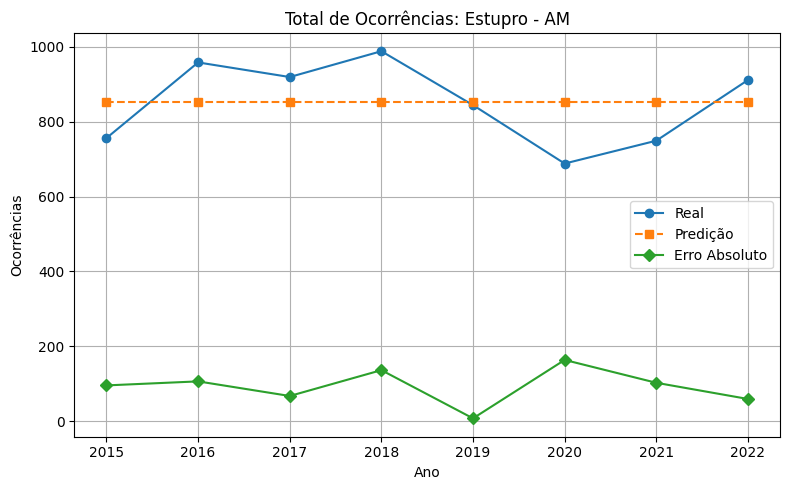


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  0.716095999604016
MAPE:  0.22565212134186596 %


Coeficientes - LASSO:
          feature        coef
0             ivs  -92.080266
1    ivs_infraurb -228.579727
2            idhm  483.583751
3            gini   94.113189
4      rendamedia    0.000000
5   txdesocupacao -161.333212
6  txeletricidade  -46.221924
7  txmortinfantil    0.000000
8    txnemnemvuln -143.574346




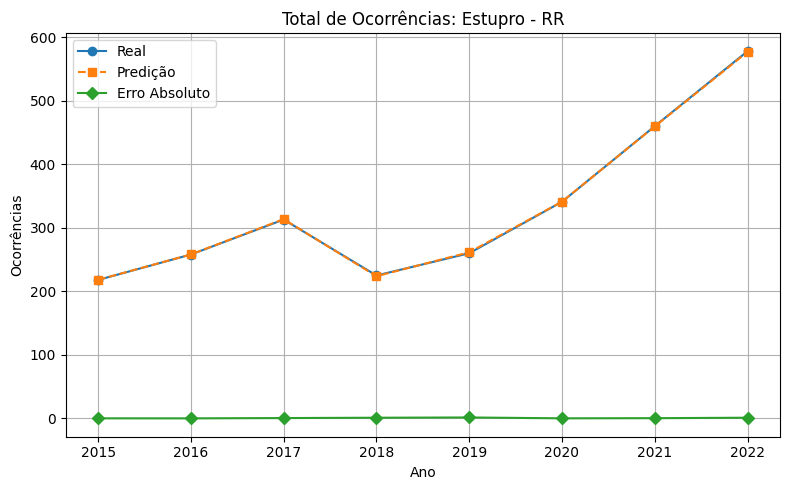


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  261391.234375
MAPE:  12.735099286134071 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm  -0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln  -0.0




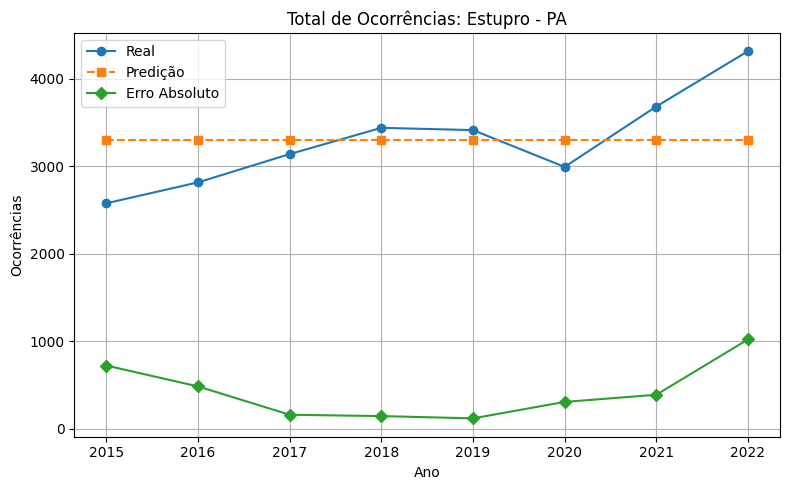


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  11577.75
MAPE:  38.019765657676444 %


Coeficientes - LASSO:
          feature  coef
0             ivs   0.0
1    ivs_infraurb  -0.0
2            idhm  -0.0
3            gini   0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade   0.0
7  txmortinfantil  -0.0
8    txnemnemvuln   0.0




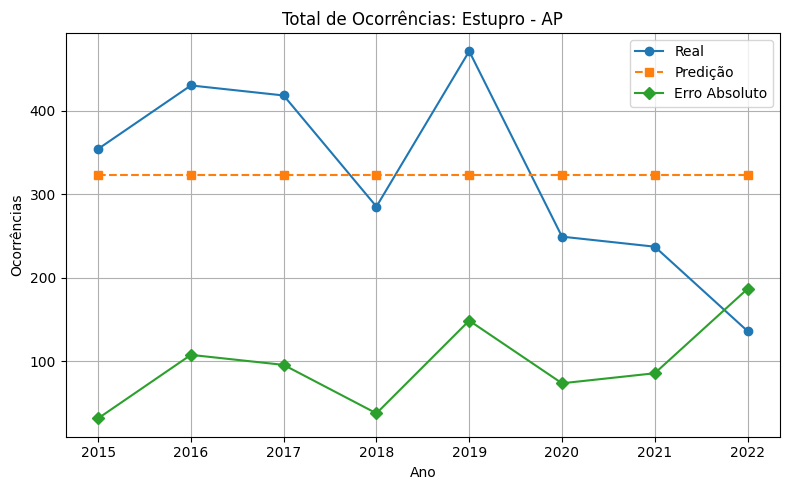


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  22896.349246808328
MAPE:  30.772025615852694 %


Coeficientes - LASSO:
          feature       coef
0             ivs   0.000000
1    ivs_infraurb  -0.000000
2            idhm   0.000000
3            gini   0.000000
4      rendamedia   0.000000
5   txdesocupacao  36.074255
6  txeletricidade   0.000000
7  txmortinfantil   0.000000
8    txnemnemvuln  -0.000000




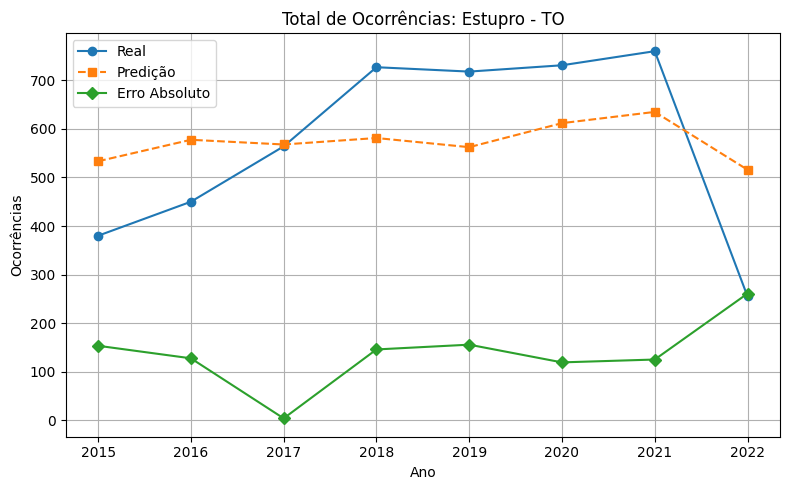


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  18.47514627482087
MAPE:  0.27467165001536914 %


Coeficientes - LASSO:
          feature        coef
0             ivs -468.908610
1    ivs_infraurb   -0.000000
2            idhm  486.015381
3            gini   -0.000000
4      rendamedia    0.000000
5   txdesocupacao -123.668171
6  txeletricidade -632.627237
7  txmortinfantil  471.015673
8    txnemnemvuln  139.566873




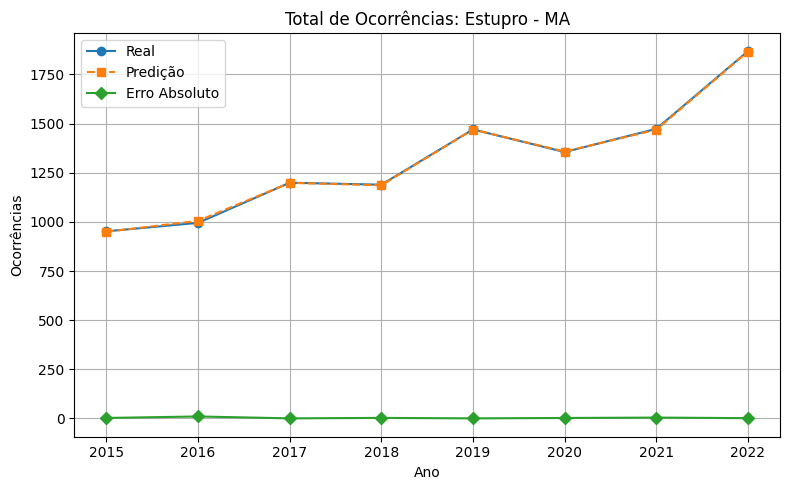


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  3773.481378791066
MAPE:  7.736750622579547 %


Coeficientes - LASSO:
          feature        coef
0             ivs -192.040810
1    ivs_infraurb  -21.900111
2            idhm  212.805628
3            gini    0.000000
4      rendamedia    0.000000
5   txdesocupacao  -33.291710
6  txeletricidade    0.000000
7  txmortinfantil    0.000000
8    txnemnemvuln   15.737288




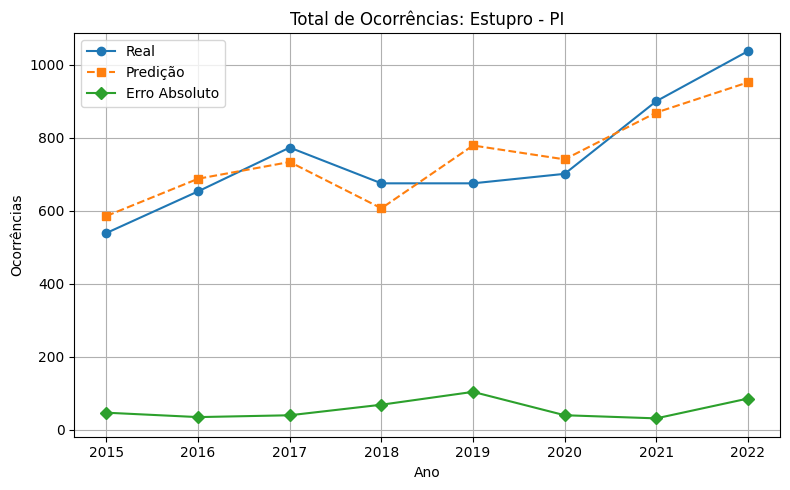


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  15043.359375
MAPE:  6.3652182870548 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm   0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao   0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln  -0.0




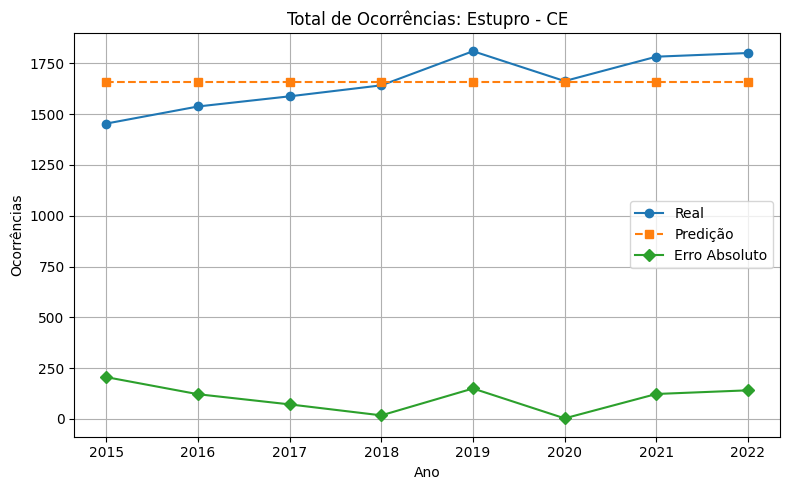


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  10139.009386236026
MAPE:  44.33923315503208 %


Coeficientes - LASSO:
          feature        coef
0             ivs -136.624980
1    ivs_infraurb  170.791922
2            idhm   79.702542
3            gini    0.000000
4      rendamedia    0.000000
5   txdesocupacao  -35.255383
6  txeletricidade   -0.000000
7  txmortinfantil    0.000000
8    txnemnemvuln -108.288693




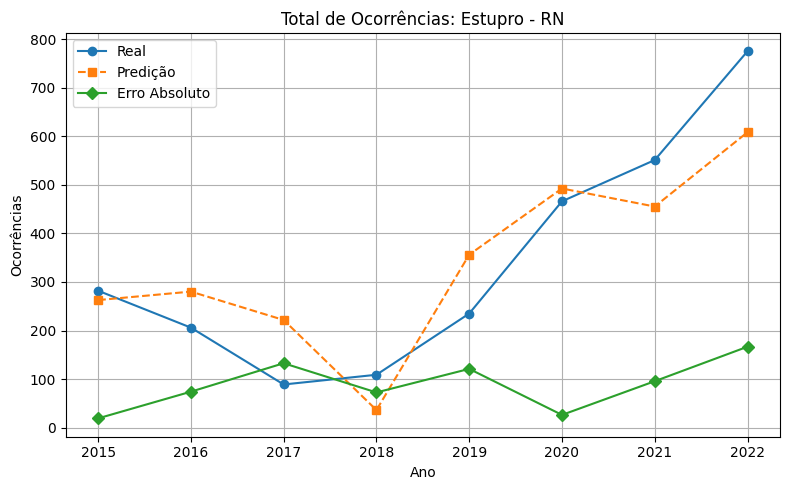


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  14797.359375
MAPE:  30.177361478851395 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb   0.0
2            idhm   0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade   0.0
7  txmortinfantil  -0.0
8    txnemnemvuln   0.0




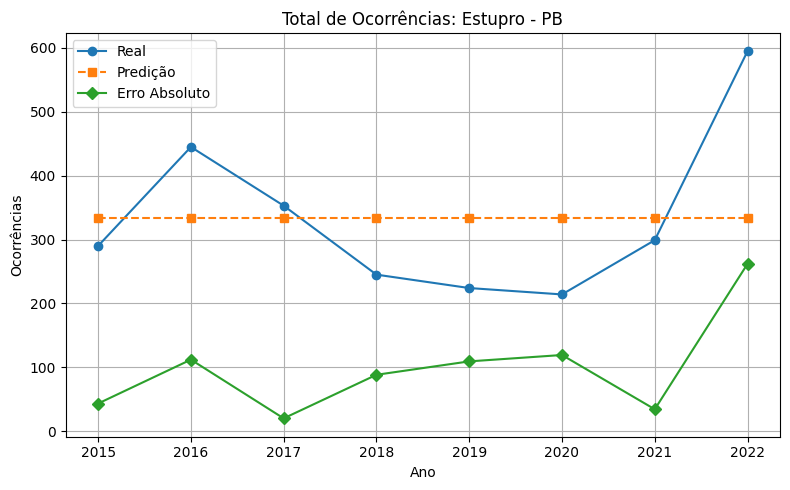


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  35115.1875
MAPE:  8.003524930411176 %


Coeficientes - LASSO:
          feature  coef
0             ivs   0.0
1    ivs_infraurb   0.0
2            idhm   0.0
3            gini   0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade   0.0
7  txmortinfantil   0.0
8    txnemnemvuln   0.0




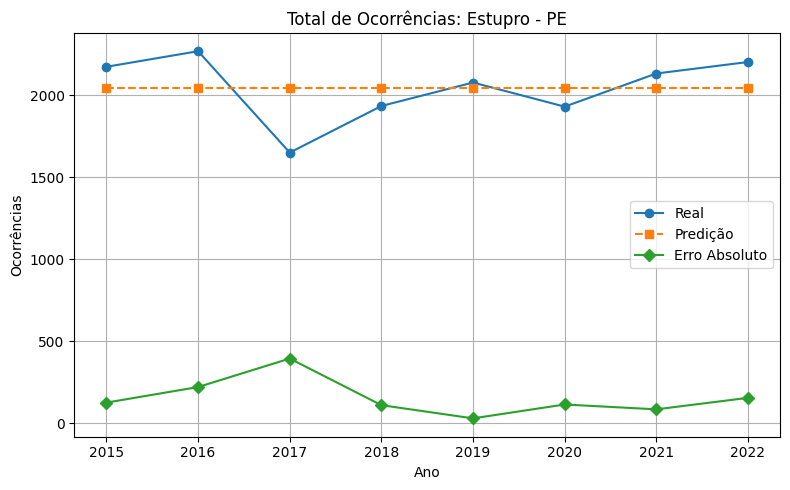


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  0.737194961809324
MAPE:  0.11491822008524682 %


Coeficientes - LASSO:
          feature        coef
0             ivs -101.441489
1    ivs_infraurb   77.647197
2            idhm  -88.057466
3            gini -194.039492
4      rendamedia    0.000000
5   txdesocupacao   43.524579
6  txeletricidade  171.393547
7  txmortinfantil   -0.000000
8    txnemnemvuln   94.612475




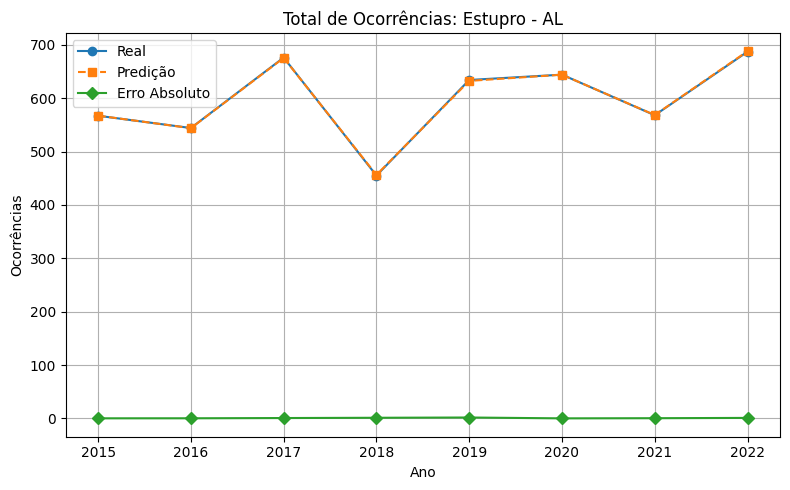


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  7110.3896718563465
MAPE:  20.104832812754537 %


Coeficientes - LASSO:
          feature       coef
0             ivs  33.503985
1    ivs_infraurb -25.940869
2            idhm -87.595472
3            gini   0.000000
4      rendamedia   0.000000
5   txdesocupacao  76.572394
6  txeletricidade  -0.000000
7  txmortinfantil  -0.000000
8    txnemnemvuln  35.758733




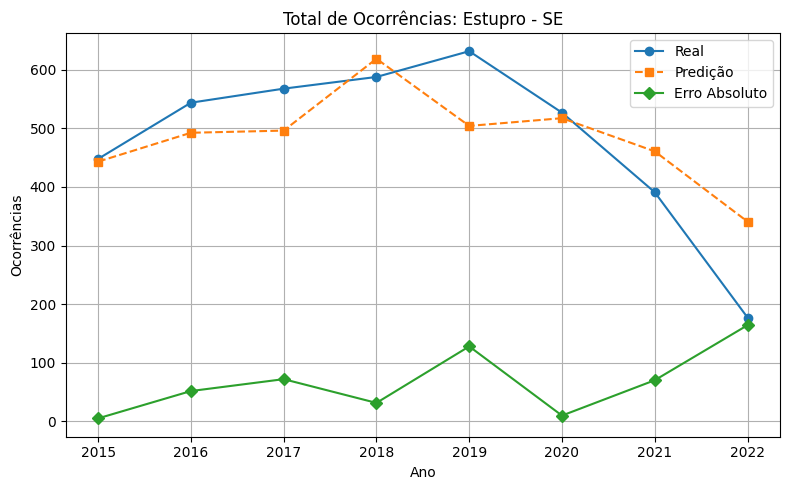


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  168314.6875
MAPE:  10.95187636358414 %


Coeficientes - LASSO:
          feature          coef
0             ivs -5.684342e-14
1    ivs_infraurb  0.000000e+00
2            idhm  0.000000e+00
3            gini -0.000000e+00
4      rendamedia  0.000000e+00
5   txdesocupacao  0.000000e+00
6  txeletricidade -0.000000e+00
7  txmortinfantil  0.000000e+00
8    txnemnemvuln -0.000000e+00




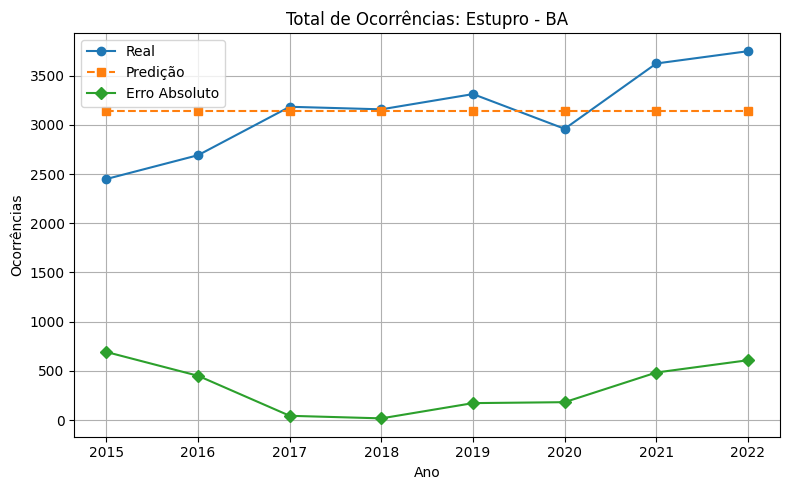


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  5543.989739617659
MAPE:  4.942636077246865 %


Coeficientes - LASSO:
          feature        coef
0             ivs  160.604820
1    ivs_infraurb -101.200345
2            idhm -268.942602
3            gini  -29.725147
4      rendamedia    0.000000
5   txdesocupacao   -8.338678
6  txeletricidade  125.829425
7  txmortinfantil   -0.000000
8    txnemnemvuln  156.664275




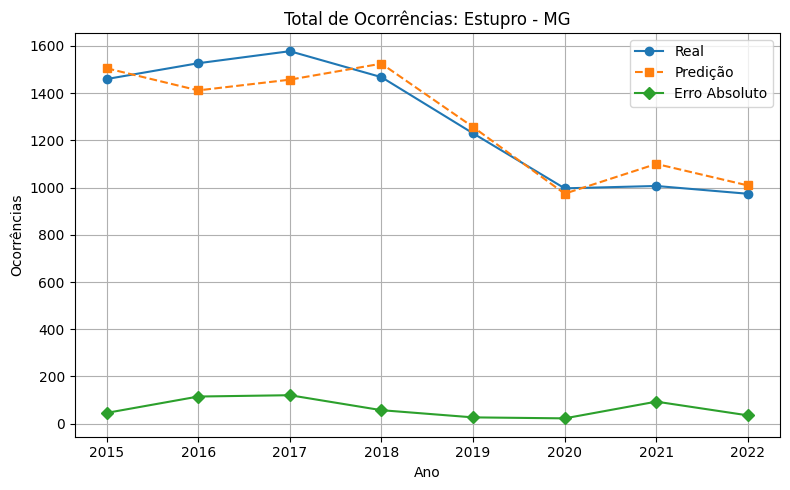


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  51022.25091633968
MAPE:  34.59919365429295 %


Coeficientes - LASSO:
          feature        coef
0             ivs -437.565252
1    ivs_infraurb    0.000000
2            idhm  675.272246
3            gini    0.000000
4      rendamedia    0.000000
5   txdesocupacao  -94.169502
6  txeletricidade   -0.000000
7  txmortinfantil    0.000000
8    txnemnemvuln -196.105336




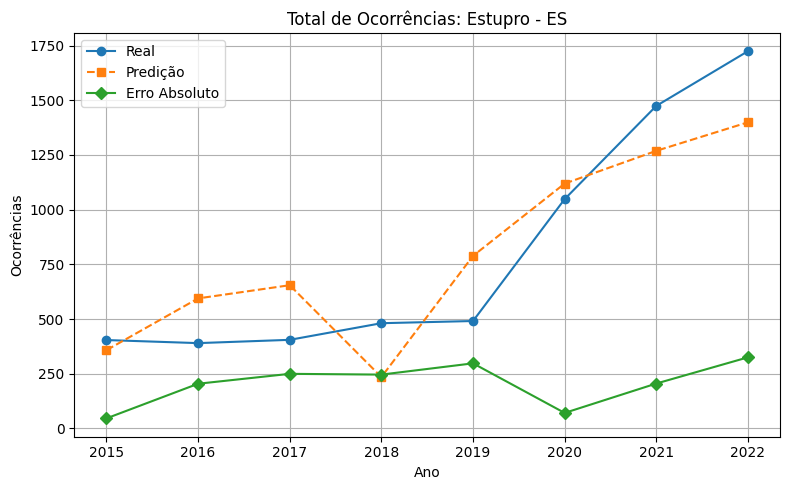


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  80416.4375
MAPE:  5.2936746617575885 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm  -0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln  -0.0




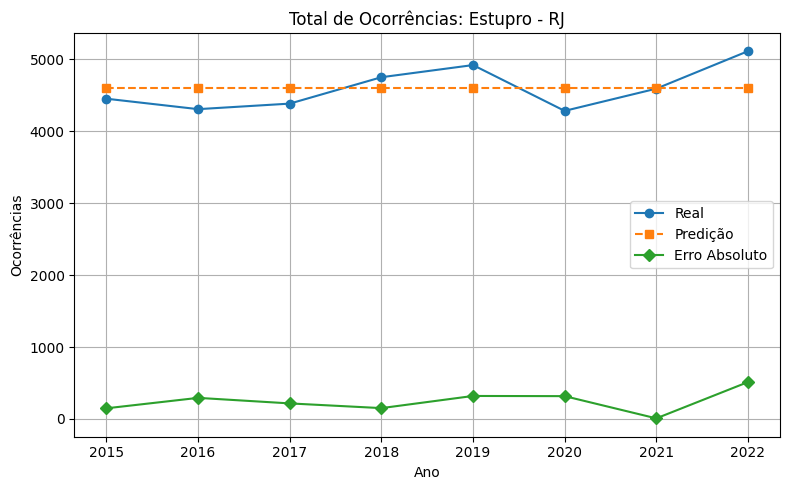


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  1017858.5
MAPE:  7.5690678932121 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm  -0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao   0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln  -0.0




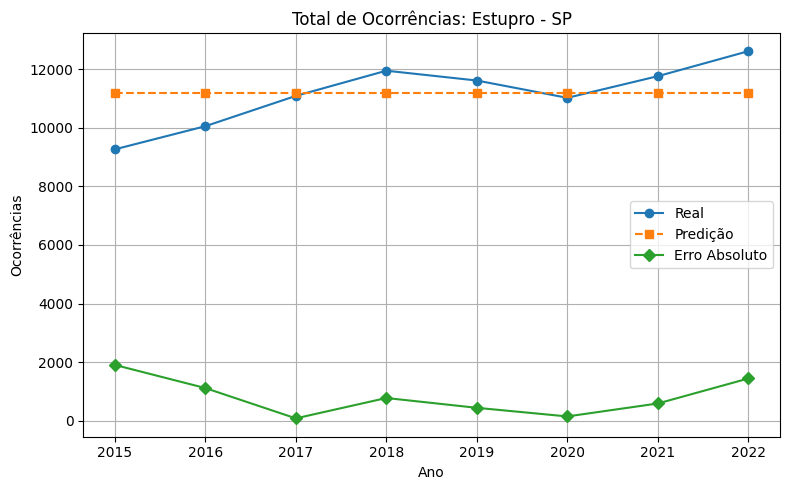


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  417690.84420923796
MAPE:  10.691013199591476 %


Coeficientes - LASSO:
          feature       coef
0             ivs -55.830650
1    ivs_infraurb -17.488562
2            idhm  -0.000000
3            gini  -0.000000
4      rendamedia   0.000000
5   txdesocupacao  -0.000000
6  txeletricidade  -0.000000
7  txmortinfantil  -0.000000
8    txnemnemvuln  -0.000000




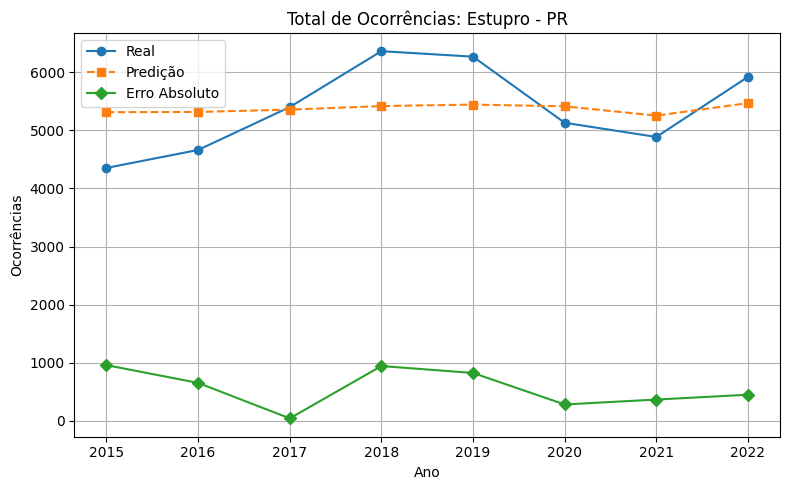


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  22843.019387475775
MAPE:  10.17378992222106 %


Coeficientes - LASSO:
          feature       coef
0             ivs -28.882704
1    ivs_infraurb  -0.000000
2            idhm  -0.000000
3            gini  -0.000000
4      rendamedia   0.000000
5   txdesocupacao   0.000000
6  txeletricidade  -0.000000
7  txmortinfantil  -0.000000
8    txnemnemvuln  -0.000000




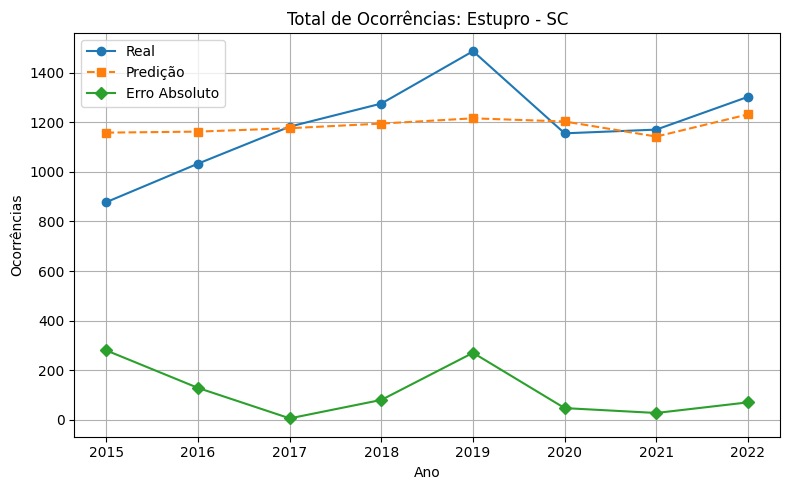


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  111187.234375
MAPE:  6.355344048154467 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm  -0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln   0.0




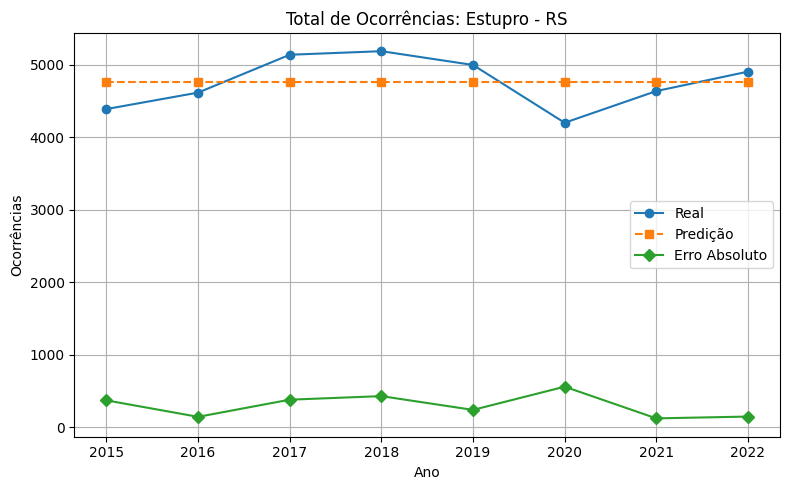


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  16988.984375
MAPE:  6.670911581080206 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm   0.0
3            gini   0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln   0.0




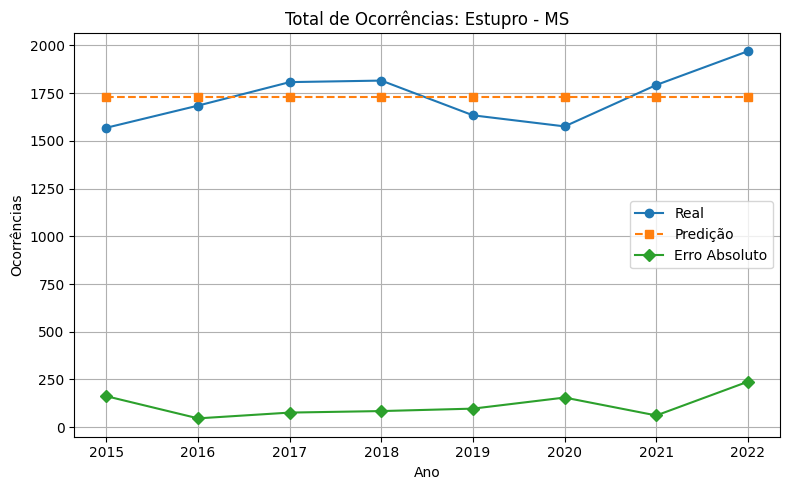


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  52858.9375
MAPE:  9.45079530213691 %


Coeficientes - LASSO:
          feature  coef
0             ivs  -0.0
1    ivs_infraurb  -0.0
2            idhm  -0.0
3            gini  -0.0
4      rendamedia   0.0
5   txdesocupacao  -0.0
6  txeletricidade  -0.0
7  txmortinfantil  -0.0
8    txnemnemvuln   0.0




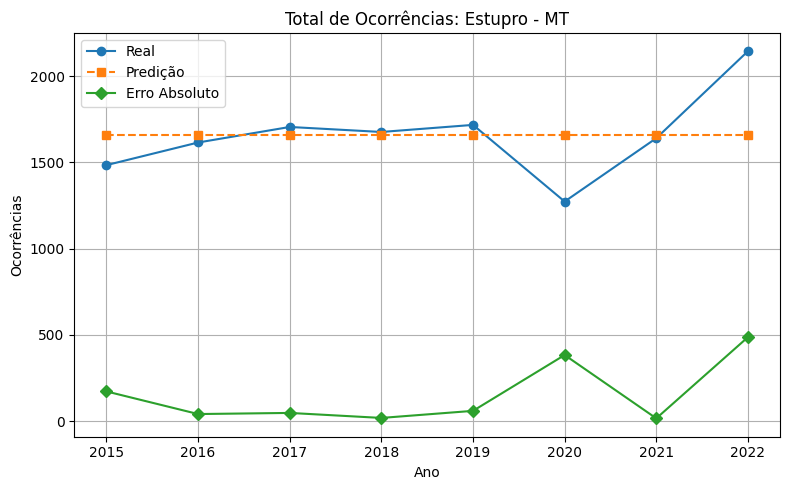


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

MSE:  2448.109375
MAPE:  5.818683388636696 %


Coeficientes - LASSO:
          feature          coef
0             ivs -7.105427e-15
1    ivs_infraurb -0.000000e+00
2            idhm -0.000000e+00
3            gini -0.000000e+00
4      rendamedia  0.000000e+00
5   txdesocupacao  0.000000e+00
6  txeletricidade -0.000000e+00
7  txmortinfantil -0.000000e+00
8    txnemnemvuln -0.000000e+00




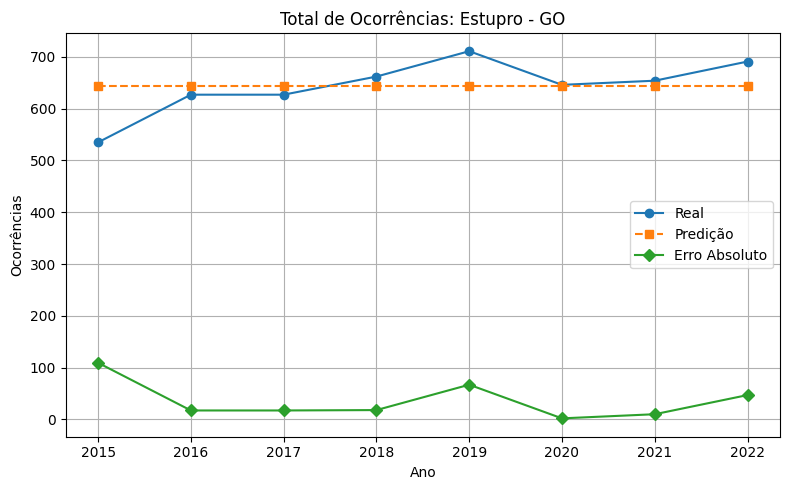


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



In [ ]:
# Modelo Preditivo: LASSO
# UF: todos, TC: 1

for i in range(1, len(d_local)):

    typec = 1
    X, y, feature_cols = get_df_features_uf(i, typec)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = LassoCV(
        cv = 2,
        max_iter = 10000,
        random_state = 7
    )

    lasso.fit(X_scaled, y)

    y_pred = lasso.predict(X_scaled)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Métricas
    print("MSE: ", mean_squared_error(y, y_pred))
    print("MAPE: ", np.mean(np.abs((y - y_pred) / (y + 0.000001))) * 100, "%")

    print("\n")
    print("Coeficientes - LASSO:")
    print(pd.DataFrame({"feature": feature_cols, "coef": lasso.coef_}))
    print("\n")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Plotagem de gráficos para cada tipo de crime no estado escolhido
# Valor real, valor predito e erro absoluto

    plt.figure(figsize=(8, 5))

    plt.plot(matching_years+2008, y, marker='o', linestyle='-', label='Real')
    plt.plot(matching_years+2008, y_pred, marker='s', linestyle='--', label='Predição')

    abs_error = np.abs(y - y_pred)
    plt.plot(matching_years+2008, abs_error, marker='D', linestyle='-', label='Erro Absoluto')

    state_ = d_local.loc[d_local['idlocal'] == i, 'uf'].iloc[0]
    typec_ = d_tipocrime.loc[d_tipocrime['idtipocrime'] == typec, 'tipocrime'].iloc[0]
    plt.title("Total de Ocorrências: " + typec_ + " - " + state_)

    plt.xlabel("Ano")
    plt.ylabel("Ocorrências")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -\n")

In [ ]:
# Modelo Preditivo: LASSO
# UF: 1, TC: todos

for i in range(1, len(d_tipocrime)):
    state = 1
    X, y, feature_cols = get_df_features_tc(state, i)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = LassoCV(
        cv = 2,
        max_iter = 10000,
        random_state = 7
    )

    lasso.fit(X_scaled, y)

    y_pred = lasso.predict(X_scaled)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Métricas
    print("MSE: ", mean_squared_error(y, y_pred))
    print("MAPE: ", np.mean(np.abs((y - y_pred) / (y + 0.000001))) * 100, "%")

    print("\n")
    print("Coeficientes - LASSO:")
    print(pd.DataFrame({"feature": feature_cols, "coef": lasso.coef_}))
    print("\n")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Plotagem de gráficos para cada tipo de crime no estado escolhido
# Valor real, valor predito e erro absoluto

    plt.figure(figsize=(8, 5))

    plt.plot(matching_years+2008, y, marker='o', linestyle='-', label='Real')
    plt.plot(matching_years+2008, y_pred, marker='s', linestyle='--', label='Predição')

    abs_error = np.abs(y - y_pred)
    plt.plot(matching_years+2008, abs_error, marker='D', linestyle='-', label='Erro Absoluto')

    crime = d_tipocrime.loc[d_tipocrime['idtipocrime'] == i, 'tipocrime'].iloc[0]
    state_ = d_local.loc[d_local['idlocal'] == state, 'uf'].iloc[0]
    plt.title("Total de Ocorrências: " + crime + " - " + state_)

    plt.xlabel("Ano")
    plt.ylabel("Ocorrências")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -\n")